## 회귀 문제 - 주택 가격 예측
- 개별적 레이블 예측 x 
- **연속적인 값을 예측하는 회귀**
- 여기서 회귀 ≠ 로지스틱 회귀
- **로지스틱 회귀는 범주형을 예측**하는 "분류" 알고리즘

### 보스턴 주택 가격 데이터셋

In [1]:
# 데이터 로드
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

### 데이터 준비

In [4]:
# 데이터 피처별 정규화
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data/=std

### 모델 구성

In [5]:
# 모델 정의
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu',
                         input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

### K-Fold Cross-Validation

In [9]:
import numpy as np

k = 4
num_val_samples = len(train_data)//k
num_epochs = 100
all_scores=[]
for i in range(k):
  print('처리중인 폴드 #', i)
  val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]

  # 다른 분할들 합침
  partial_train_data = np.concatenate(
   [train_data[:i*num_val_samples],
    train_data[(i+1)*num_val_samples:]],
    axis=0   
  )
  partial_train_targets = np.concatenate(
   [train_targets[:i*num_val_samples],
    train_targets[(i+1)*num_val_samples:]],
    axis=0   
  )
  model = build_model() # 컴파일 포함됨
  model.fit(partial_train_data, partial_train_targets, epochs=num_epochs,
          batch_size=1, verbose=0) # verbose=0 : 훈련과정 출력x
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [10]:
all_scores

[2.1699695587158203, 2.8286359310150146, 2.803055763244629, 2.403719425201416]

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [23]:
# 훈련 루프 수정하여 에폭 검증 점수를 로그에 저장
# 에폭 수 500으로 늘려서 훈련

num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('처리중인 폴드 #', i)
  val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]

  # 다른 분할들 합침
  partial_train_data = np.concatenate(
   [train_data[:i*num_val_samples],
    train_data[(i+1)*num_val_samples:]],
    axis=0   
  )
  partial_train_targets = np.concatenate(
   [train_targets[:i*num_val_samples],
    train_targets[(i+1)*num_val_samples:]],
    axis=0   
  )
  model = build_model() # 컴파일 포함됨
  history = model.fit(partial_train_data, partial_train_targets, 
          validation_data = (val_data, val_targets),
          epochs=num_epochs,
          batch_size=1, verbose=0) # verbose=0 : 훈련과정 출력x
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [24]:
# 모든 폴드에 대해 에폭의 mae 점수 평균 계산
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

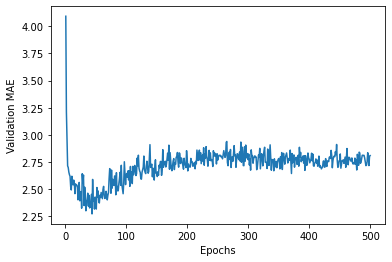

In [25]:
# 검증 점수 그래프
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

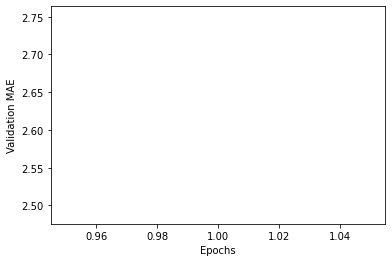

In [39]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor + point*(1-factor))
    else:
      smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [40]:
# 최종 모델 훈련
model = build_model()
model.fit(train_data, train_targets, 
          epochs =80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 6095472.5000 - mae: 2410.2258


In [41]:
test_mae_score

2410.225830078125